# Models 2

Group project for the 2019 Data Science Workshop at the University of California, Berkeley.

The project is the Google Analytics Customer Revenue Prediction competition on Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction

Group members:

* Andy Vargas (mentor)
* Yuem Park
* Marvin Pohl
* Michael Yeh

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.random import sample_without_replacement

pd.options.display.max_columns = 999

In [2]:
data_match = pd.read_csv('./data/train_df_match.csv', dtype={'fullVisitorId':'str'})
data_01 = pd.read_csv('./data/train_df_01.csv', dtype={'fullVisitorId':'str'})
data_02 = pd.read_csv('./data/train_df_02.csv', dtype={'fullVisitorId':'str'})
data_03 = pd.read_csv('./data/train_df_03.csv', dtype={'fullVisitorId':'str'})
data_04 = pd.read_csv('./data/train_df_04.csv', dtype={'fullVisitorId':'str'})
data_05 = pd.read_csv('./data/train_df_05.csv', dtype={'fullVisitorId':'str'})

In [3]:
# get rid of some features
training_cols = []
for col in data_match.columns:
    if ('trafficSource.medium.' not in col) and (col != 'totals.sessionQualityDim'):
        training_cols.append(col)

all_data = [data_match, data_01, data_02, data_03, data_04, data_05]

for i in range(len(all_data)):
    
    # add a column for DNR, RZR, RPR
    all_data[i].loc[all_data[i]['return_flag']==0,'stratify_flag']='DNR'
    all_data[i].loc[(all_data[i]['return_flag']==1)&(all_data[i]['total_predict_revenue']==0),'stratify_flag']='RZR'
    all_data[i].loc[(all_data[i]['return_flag']==1)&(all_data[i]['total_predict_revenue']!=0),'stratify_flag']='RPR'
    
# pull out only RPR data
data_match = data_match[data_match['stratify_flag']=='RPR'].copy()
data_01 = data_01[data_01['stratify_flag']=='RPR'].copy()
data_02 = data_02[data_02['stratify_flag']=='RPR'].copy()
data_03 = data_03[data_03['stratify_flag']=='RPR'].copy()
data_04 = data_04[data_04['stratify_flag']=='RPR'].copy()
data_05 = data_05[data_05['stratify_flag']=='RPR'].copy()

data_match.reset_index(drop=True, inplace=True)
data_01.reset_index(drop=True, inplace=True)
data_02.reset_index(drop=True, inplace=True)
data_03.reset_index(drop=True, inplace=True)
data_04.reset_index(drop=True, inplace=True)
data_05.reset_index(drop=True, inplace=True)

# get rid of some of the features
data_match = data_match[training_cols]
data_01 = data_01[training_cols]
data_02 = data_02[training_cols]
data_03 = data_03[training_cols]
data_04 = data_04[training_cols]
data_05 = data_05[training_cols]

# combine the XX dataframes
data_XX = pd.concat([data_01,data_02,data_03,data_04,data_05], ignore_index=True)

# get feature and target column names
X_cols = []
for col in data_match.columns:
    if (col!='total_predict_revenue') and (col!='return_flag') and (col!='stratify_flag') and (col!='fullVisitorId'):
        X_cols.append(col)
        
Y_cols = ['total_predict_revenue']

# split features and targets
X_match = data_match[X_cols]
Y_match = data_match[Y_cols]

X_XX = data_XX[X_cols]
Y_XX = data_XX[Y_cols]

# standardize features
scaler = StandardScaler()
X_match = scaler.fit_transform(X_match)
X_XX = scaler.fit_transform(X_XX)

# put back into dataframe
X_match = pd.DataFrame(data=X_match, columns=X_cols)
X_XX = pd.DataFrame(data=X_XX, columns=X_cols)

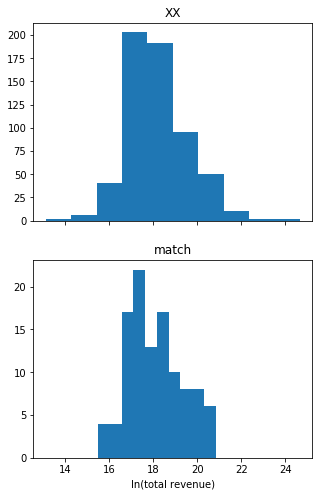

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,8), sharex=True)

ax[0].hist(np.log(Y_XX.values.ravel()))
ax[0].set_title('XX')

ax[1].hist(np.log(Y_match.values.ravel()))
ax[1].set_title('match')
ax[1].set_xlabel('ln(total revenue)')

plt.show(fig)

In [5]:
X_cols

['channelGrouping.(Other)',
 'channelGrouping.Affiliates',
 'channelGrouping.Direct',
 'channelGrouping.Display',
 'channelGrouping.Organic Search',
 'channelGrouping.Paid Search',
 'channelGrouping.Referral',
 'channelGrouping.Social',
 'device.browser.Android Webview',
 'device.browser.Chrome',
 'device.browser.Firefox',
 'device.browser.Internet Explorer',
 'device.browser.OTHER',
 'device.browser.Safari',
 'device.operatingSystem.(not set)',
 'device.operatingSystem.Android',
 'device.operatingSystem.Chrome OS',
 'device.operatingSystem.Linux',
 'device.operatingSystem.Macintosh',
 'device.operatingSystem.OTHER',
 'device.operatingSystem.Windows',
 'device.operatingSystem.iOS',
 'geoNetwork.subContinent.Eastern Asia',
 'geoNetwork.subContinent.Northern America',
 'geoNetwork.subContinent.Northern Europe',
 'geoNetwork.subContinent.OTHER',
 'geoNetwork.subContinent.Southeast Asia',
 'geoNetwork.subContinent.Southern Asia',
 'geoNetwork.subContinent.Western Europe',
 'trafficSource.s

In [6]:
def get_RMSE(Y, Y_prediction):
    RMSE = np.sqrt(mean_squared_error(np.log(Y+1), np.log(Y_prediction+1)))
    return RMSE

# scorer
scorer = make_scorer(get_RMSE, greater_is_better=False)

## RFR

In [7]:
# the hyperparameter search grid
n_estimators_HPT_1 = np.array([100,200,300,400])
max_depth_HPT_1 = np.arange(1, 11, 1)
min_samples_leaf_HPT_1 = np.arange(5, 16, 1)

param_grid = {'n_estimators':n_estimators_HPT_1,
              'max_depth':max_depth_HPT_1,
              'min_samples_leaf':min_samples_leaf_HPT_1}

# the regressor
RFR = RandomForestRegressor(random_state=1111)
    
# kfold for the inner and outer loops
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2222)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=2019)

# non-nested parameter search and scoring
GSCV = GridSearchCV(estimator=RFR, param_grid=param_grid, cv=inner_cv,
                    scoring=scorer, iid=False)
GSCV.fit(X_match, Y_match.values.ravel())

# get performance for each of the hyperparameters
GSCV_params_1 = pd.DataFrame(GSCV.cv_results_['params'])
GSCV_params_1['mean_test_RMSE'] = np.abs(GSCV.cv_results_['mean_test_score'])
GSCV_params_1['std_test_RMSE'] = GSCV.cv_results_['std_test_score']

# nested CV
nested_score_1 = cross_validate(GSCV.best_estimator_, X=X_match, y=Y_match.values.ravel(),
                              cv=outer_cv, scoring=scorer, return_estimator=True)

print('outer cross-validation results:')
print('-------------------------------')
print("%0.3f (+/-%0.03f) for %r"
      % (abs(nested_score_1['test_score'].mean()), nested_score_1['test_score'].std(), GSCV.best_params_))

outer cross-validation results:
-------------------------------
1.391 (+/-0.186) for {'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 200}


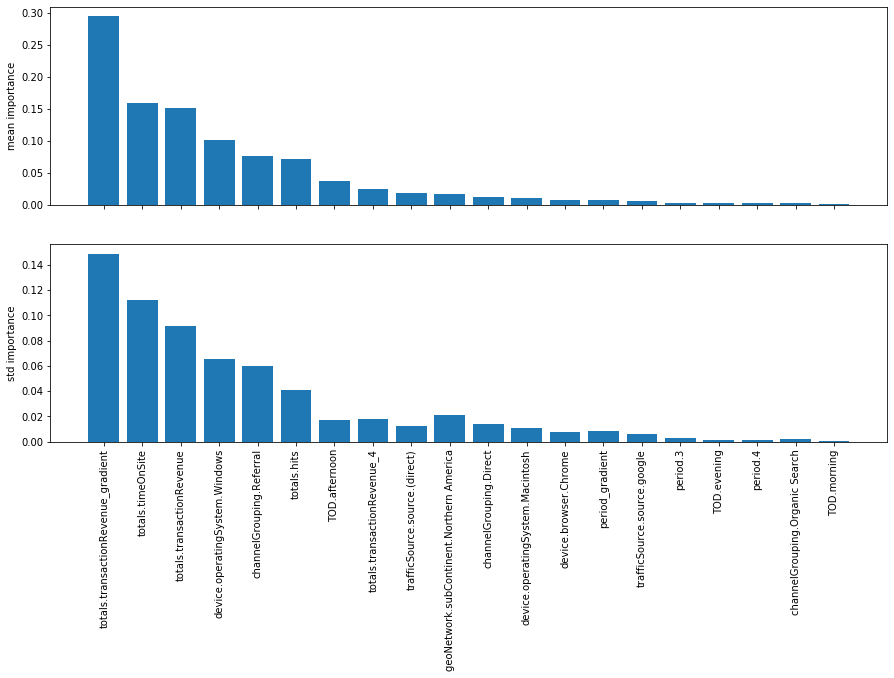

In [8]:
feature_importances = pd.DataFrame({'feature':X_match.columns})

feature_importances_vals = np.zeros((len(feature_importances), len(nested_score_1['estimator'])))

for i in range(len(nested_score_1['estimator'])):
    feature_importances_vals[:,i] = nested_score_1['estimator'][i].feature_importances_
    
feature_importances['importance'] = np.mean(feature_importances_vals, axis=1)
feature_importances['std'] = np.std(feature_importances_vals, axis=1)
feature_importances.sort_values('importance', ascending=False, inplace=True)
feature_importances.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8), sharex=True)

cut_off = 20

x_inds = np.arange(cut_off)

ax[0].bar(x_inds, feature_importances['importance'][:cut_off])
ax[0].set_ylabel('mean importance')

ax[1].bar(x_inds, feature_importances['std'][:cut_off])
ax[1].set_ylabel('std importance')

ax[1].set_xticks(x_inds)
ax[1].set_xticklabels(feature_importances['feature'][:cut_off], rotation=90)

plt.show(fig)

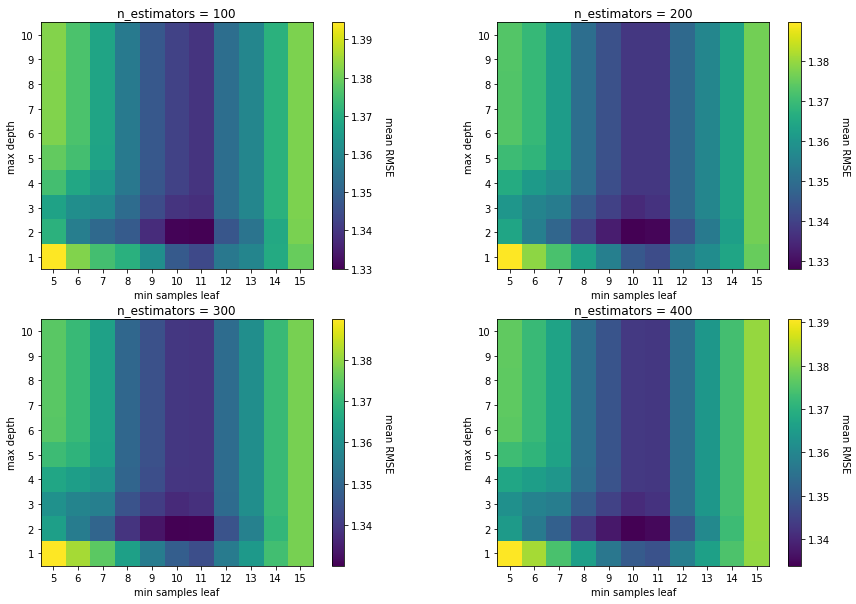

In [9]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_1)):
    
    params_slice = GSCV_params_1[GSCV_params_1['n_estimators']==n_estimators_HPT_1[i]].copy()
    params_slice = params_slice.pivot(index='max_depth', columns='min_samples_leaf', values='mean_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_1[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_1)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_1)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_1)))
    ax[i].set_yticklabels(max_depth_HPT_1)
    ax[i].set_ylabel('max depth')
    
plt.show(fig)

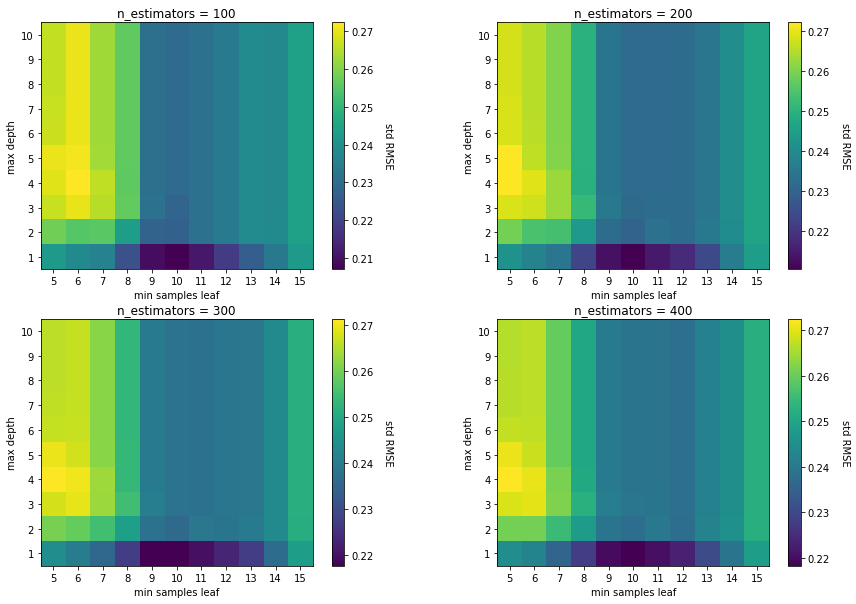

In [10]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_1)):
    
    params_slice = GSCV_params_1[GSCV_params_1['n_estimators']==n_estimators_HPT_1[i]].copy()
    params_slice = params_slice.pivot(index='max_depth', columns='min_samples_leaf', values='std_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('std RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_1[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_1)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_1)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_1)))
    ax[i].set_yticklabels(max_depth_HPT_1)
    ax[i].set_ylabel('max depth')
    
plt.show(fig)

### Subset of Features

In [11]:
simple_mean_RMSEs = np.array([])
simple_std_RMSEs = np.array([])

i_start = 2
i_end = 31

for i in range(i_start, i_end):
    
    X_cols_simple = feature_importances['feature'][:i]
    
    X_match_simple = X_match[X_cols_simple]
    
    nested_score = cross_validate(GSCV.best_estimator_, X=X_match_simple, y=Y_match.values.ravel(),
                                  cv=outer_cv, scoring=scorer, return_estimator=True)
    
    simple_mean_RMSEs = np.append(simple_mean_RMSEs, nested_score['test_score'].mean())
    simple_std_RMSEs = np.append(simple_std_RMSEs, nested_score['test_score'].std())

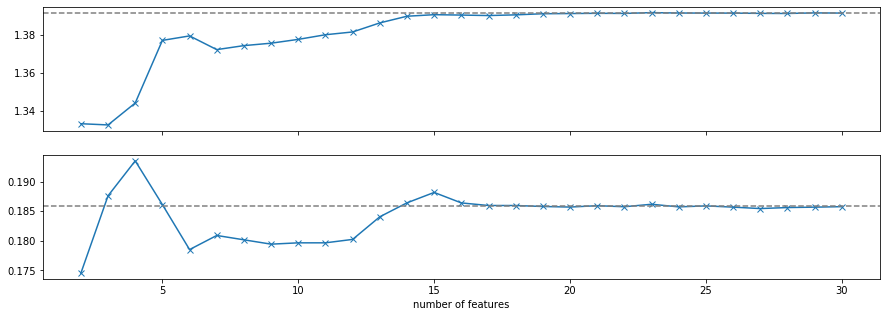

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5), sharex=True)

ax[0].plot(np.arange(i_start, i_end), np.abs(simple_mean_RMSEs), 'x-')
ax[0].axhline(np.abs(nested_score_1['test_score'].mean()), ls='--', c='C7')

ax[1].plot(np.arange(i_start, i_end), simple_std_RMSEs, 'x-')
ax[1].axhline(nested_score_1['test_score'].std(), ls='--', c='C7')

ax[1].set_xlabel('number of features')

plt.show(fig)

### Fine Tune

In [13]:
X_cols_simple = feature_importances['feature'][:3]

X_match_simple = X_match[X_cols_simple]

# the hyperparameter search grid
n_estimators_HPT_2 = np.array([100,200,300,400])
max_depth_HPT_2 = np.arange(1, 11, 1)
min_samples_leaf_HPT_2 = np.arange(1, 11, 1)

param_grid = {'n_estimators':n_estimators_HPT_2,
              'max_depth':max_depth_HPT_2,
              'min_samples_leaf':min_samples_leaf_HPT_2}

# the regressor
RFR = RandomForestRegressor(random_state=1111)
    
# kfold for the inner and outer loops
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2222)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=2019)

# non-nested parameter search and scoring
GSCV = GridSearchCV(estimator=RFR, param_grid=param_grid, cv=inner_cv,
                    scoring=scorer, iid=False)
GSCV.fit(X_match_simple, Y_match.values.ravel())

# get performance for each of the hyperparameters
GSCV_params_2 = pd.DataFrame(GSCV.cv_results_['params'])
GSCV_params_2['mean_test_RMSE'] = np.abs(GSCV.cv_results_['mean_test_score'])
GSCV_params_2['std_test_RMSE'] = GSCV.cv_results_['std_test_score']

# nested CV
nested_score_2 = cross_validate(GSCV.best_estimator_, X=X_match_simple, y=Y_match.values.ravel(),
                              cv=outer_cv, scoring=scorer, return_estimator=True)

print('outer cross-validation results:')
print('-------------------------------')
print("%0.3f (+/-%0.03f) for %r"
      % (abs(nested_score_2['test_score'].mean()), nested_score_2['test_score'].std(), GSCV.best_params_))

outer cross-validation results:
-------------------------------
1.313 (+/-0.209) for {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 200}


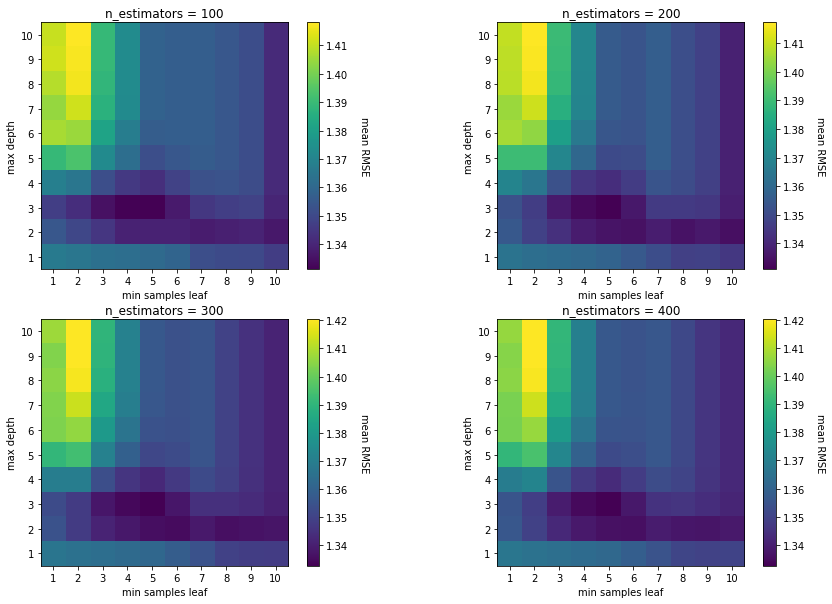

In [14]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_2)):
    
    params_slice = GSCV_params_2[GSCV_params_2['n_estimators']==n_estimators_HPT_2[i]].copy()
    params_slice = params_slice.pivot(index='max_depth', columns='min_samples_leaf', values='mean_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_2[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_2)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_2)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_2)))
    ax[i].set_yticklabels(max_depth_HPT_2)
    ax[i].set_ylabel('max depth')
    
plt.show(fig)

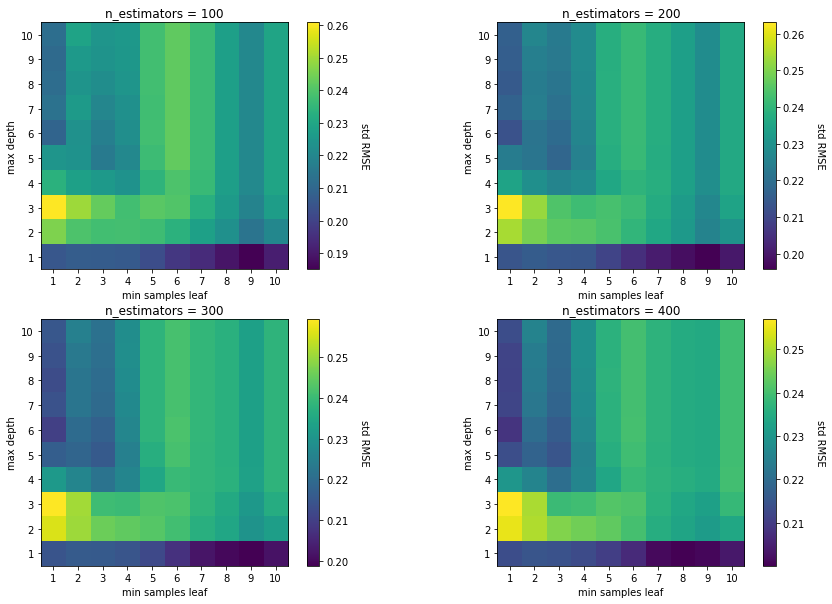

In [15]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_2)):
    
    params_slice = GSCV_params_2[GSCV_params_2['n_estimators']==n_estimators_HPT_2[i]].copy()
    params_slice = params_slice.pivot(index='max_depth', columns='min_samples_leaf', values='std_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('std RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_2[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_2)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_2)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_2)))
    ax[i].set_yticklabels(max_depth_HPT_2)
    ax[i].set_ylabel('max depth')
    
plt.show(fig)

#### Actual Prediction

In [16]:
data_match_all = pd.read_csv('./data/train_df_match.csv', dtype={'fullVisitorId':'str'})

# split features and targets
X_match_all = data_match_all[X_cols_simple].copy()
Y_match_all = data_match_all[Y_cols].copy()

# standardize features
scaler = StandardScaler()
X_match_all = scaler.fit_transform(X_match_all)

# put back into dataframe
X_match_all = pd.DataFrame(data=X_match_all, columns=X_cols_simple)

# RFR
best_RFR = RandomForestRegressor(max_depth=3,
                                 min_samples_leaf=5,
                                 n_estimators=200,
                                 random_state=1111)

# fit
best_RFR.fit(X_match_simple, Y_match.values.ravel())

# predict
best_RFR_prediction_train = best_RFR.predict(X_match_all)

# store
best_RFR_train_df = X_match_all.copy()
best_RFR_train_df['prediction'] = best_RFR_prediction_train
best_RFR_train_df['observed'] = Y_match_all
best_RFR_train_df['fullVisitorId'] = data_match_all['fullVisitorId']
best_RFR_train_df = best_RFR_train_df[['fullVisitorId','observed','prediction']]
best_RFR_train_df.to_csv('RFR_prediction_train.csv', index=False)

In [17]:
best_RFR_train_df.head()

feature,fullVisitorId,observed,prediction
0,0000049363351866189,0.0,3.843586e+08
1,0000062267706107999,0.0,3.843586e+08
2,0000085059828173212,0.0,3.843586e+08
3,0000085840370633780,0.0,3.843586e+08
4,0000091131414287111,0.0,3.843586e+08


In [18]:
test = pd.read_csv('./data/test_df.csv', dtype={'fullVisitorId':'str'})

# get features
X_test = test[X_cols_simple].copy()

# standardize features
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# put back into dataframe
X_test = pd.DataFrame(data=X_test, columns=X_cols_simple)

# RFR
best_RFR = RandomForestRegressor(max_depth=3,
                                 min_samples_leaf=5,
                                 n_estimators=200,
                                 random_state=1111)

# fit
best_RFR.fit(X_match_simple, Y_match.values.ravel())

# predict
best_RFR_prediction = best_RFR.predict(X_test)

# store
best_RFR_test_df = X_test.copy()
best_RFR_test_df['prediction'] = best_RFR_prediction
best_RFR_test_df['fullVisitorId'] = test['fullVisitorId']
best_RFR_test_df = best_RFR_test_df[['fullVisitorId','prediction']]
best_RFR_test_df.to_csv('RFR_prediction_test.csv', index=False)

In [19]:
best_RFR_test_df.head()

feature,fullVisitorId,prediction
0,0000018966949534117,3.734432e+08
1,0000039738481224681,3.843586e+08
2,0000073585230191399,3.843586e+08
3,0000087588448856385,3.843586e+08
4,0000149787903119437,3.843586e+08


## Linear Regression

In [20]:
def get_RMSE_LR(Y, Y_prediction):
    Y_prediction_masked = Y_prediction.copy()
    Y_prediction_masked[Y_prediction_masked<0] = 0
    RMSE = np.sqrt(mean_squared_error(np.log(Y+1), np.log(Y_prediction_masked+1)))
    return RMSE

scorer_LR = make_scorer(get_RMSE_LR, greater_is_better=False)

In [21]:
LR = LinearRegression(normalize=False)

RMSE_LR = cross_val_score(LR, X=X_match_simple, y=Y_match.values.ravel(),
                          cv=outer_cv, scoring=scorer_LR)

print('LR RMSE = {:.3f}'.format(np.mean(np.abs(RMSE_LR))))

LR RMSE = 2.060


## GBR

In [22]:
# the hyperparameter search grid
n_estimators_HPT_3 = np.array([100,200,300,400])
learning_rate_HPT_3 = np.array([0.001,0.01,0.1,0.5])
max_depth_HPT_3 = np.arange(1, 11, 1)
min_samples_leaf_HPT_3 = np.arange(1, 11, 1)

param_grid = {'n_estimators':n_estimators_HPT_3,
              'learning_rate':learning_rate_HPT_3,
              'max_depth':max_depth_HPT_3,
              'min_samples_leaf':min_samples_leaf_HPT_3}

# the regressor
GBR = GradientBoostingRegressor(random_state=1111)
    
# kfold for the inner and outer loops
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2222)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=2019)

# non-nested parameter search and scoring
GSCV = GridSearchCV(estimator=GBR, param_grid=param_grid, cv=inner_cv,
                    scoring=scorer_LR, iid=False)
GSCV.fit(X_match_simple, Y_match.values.ravel())

# get performance for each of the hyperparameters
GSCV_params_3 = pd.DataFrame(GSCV.cv_results_['params'])
GSCV_params_3['mean_test_RMSE'] = np.abs(GSCV.cv_results_['mean_test_score'])
GSCV_params_3['std_test_RMSE'] = GSCV.cv_results_['std_test_score']

# nested CV
nested_score_3 = cross_validate(GSCV.best_estimator_, X=X_match_simple, y=Y_match.values.ravel(),
                              cv=outer_cv, scoring=scorer_LR, return_estimator=True)

print('outer cross-validation results:')
print('-------------------------------')
print("%0.3f (+/-%0.03f) for %r"
      % (abs(nested_score_3['test_score'].mean()), nested_score_3['test_score'].std(), GSCV.best_params_))

outer cross-validation results:
-------------------------------
1.349 (+/-0.162) for {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 6, 'n_estimators': 200}
